In [1]:
%cd ~/SSMuLA

/disk2/fli/SSMuLA


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic

In [16]:
import os
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm
from copy import deepcopy

from scipy.stats import skew, kurtosis, cauchy, gaussian_kde
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt

from SSMuLA.landscape_global import LibData
from SSMuLA.vis import save_plt, LIB_COLORS
from SSMuLA.util import checkNgen_folder, get_file_name

In [51]:
"""
Contains classes for dataprocessing in this work
"""
from __future__ import annotations

import warnings

warnings.simplefilter("ignore")

from functools import reduce

import os
from glob import glob
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, skew, kurtosis, cauchy, gaussian_kde
from scipy.signal import argrelextrema

from Bio.Seq import Seq

import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv

hv.extension("bokeh")


from SSMuLA.landscape_global import (
    ACTIVE_THRESH_DICT,
    LIB_INFO_DICT,
    LIB_NAMES,
    LibData,
    append_active_cutoff,
)
from SSMuLA.vis import (
    save_plt,
    save_bokeh_hv,
    plot_fit_dist,
    LIB_COLORS,
    LIB_COLORS_CODON,
)
from SSMuLA.util import checkNgen_folder, get_file_name


class ProcessData(LibData):
    """
    A parent class to process the data
    """

    def __init__(self, input_csv: str, scale_fit: str) -> None:

        """
        Args:
        - input_csv, str: path to the input csv file
        - scale_fit, str: ways to scale the fitness
            'parent' means the parent fitness = 1
            'max' means max fitness = 1
        """

        super().__init__(input_csv, scale_fit)

        print(f"Processing {self._input_csv} with {self._scale_fit}...")

    def _convert_muts(self, muts: str) -> str:

        """
        Convert the variants sequence
        to the form of parentaa1loc1mutaa1:parentaa2loc2mutaa2
        for mut number count d2m and s2m
        """

        mut_seq = ""
        mut_num = 0

        for i, (mut, wt) in enumerate(zip(muts, self.parent_aa)):
            # get wt aa + mut position from ie
            # "TrpB4": {
            #     "positions": {1: 183, 2: 184, 3: 227, 4: 228},
            #     "codons": {1: "GTG", 2: "TTC", 3: "GTG", 4: "AGC"},
            #     "AAs": {1: "V", 2: "F", 3: "V", 4: "S"}
            # }

            wt_aa_pos = LIB_INFO_DICT[self.lib_name]["AAs"][i + 1] + str(
                LIB_INFO_DICT[self.lib_name]["positions"][i + 1]
            )

            if mut != wt:
                mut_num += 1
                if mut_num != 1:
                    mut_seq += ":" + wt_aa_pos + mut
                else:
                    mut_seq += wt_aa_pos + mut
        return mut_seq

    def _append_mut(self, df: pd.DataFrame) -> pd.DataFrame:

        """
        Apply the convert_muts function to the dataframe
        """

        df_appended = df.copy()
        df_appended.loc[:, "muts"] = df_appended.apply(
            lambda x: self._convert_muts(x["AAs"]),
            axis=1,
        )

        return df_appended.replace("", "WT")

    @property
    def output_csv(self) -> str:

        """Return the path to the output csv"""

        output_csv = self._input_csv.replace("fitness_landscape", self.scale_type)
        # check if the folder exists
        checkNgen_folder(output_csv)

        return output_csv

    @property
    def dist_dir(self) -> str:
        """Return the path to the distribution directory"""
        return checkNgen_folder(
            os.path.join("results", "fitness_distribution", self._scale_fit)
        )


class ProcessDHFR(ProcessData):
    """
    Class to clean up the DHFR data
    """

    def __init__(
        self,
        input_csv: str = "data/DHFR/fitness_landscape/DHFR.csv",
        scale_fit: str = "parent",
    ) -> None:

        """
        Args:
        - input_csv, str: path to the input csv file
        - scale_fit, str: ways to scale the fitness
        """

        super().__init__(input_csv, scale_fit)

        # append the active cutoffs
        (
            self._df_avg_aa_append_scaled,
            self._avg_aa_active_cutoff_scaled,
        ) = append_active_cutoff(self.df_avg_aa_scaled, ["fitness"])

        print(f"Save processed df to {self.output_csv}...")
        # save the appended dataframe
        self._append_mut(self._df_avg_aa_append_scaled).to_csv(
            self.output_csv, index=False
        )

        self._ks, self._ks_p = ks_2samp(self.codon_fit_scaled, self.avg_aa_fit_scaled)
        print(f"Kolmogorov-Smirnov Statistic: {self._ks}")
        print(f"P-value: {self._ks_p}")

        print("Plotting the fitness distribution...")
        self._overlay_fit_dist()

    def _scale_df(self, df: pd.DataFrame, codon_aa: str) -> pd.DataFrame:
        """
        Return the exp of the fitness

        Args:
        - df, pd.DataFrame: the input dataframe
        - codon_aa, str: whether to scale the fitness to codon or amino acid
        """

        df = df.copy()

        if self._scale_fit == "parent":
            if codon_aa == "codon":
                norm_factor = self.parent_codon_fitness
            elif codon_aa == "AA":
                norm_factor = self.parent_aa_fitness
        elif self._scale_fit == "max":
            norm_factor = df["fitness"].max()

        df["fitness"] = df["fitness"] / norm_factor

        return df

    def _overlay_fit_dist(self) -> hv.Distribution:

        """
        Plot the fitness distribution

        Returns:
        - hv.Distribution: plot of the fitness distribution
        """

        print(
            f"After scaling, the parent codone fitness is {self.parent_codon_fitness_scaled}..."
        )
        print(f"The parent aa fitness is {self.parent_aa_fitness_scaled}...")
        print(
            f"The avg_aa_active_cutoff_scaled is {self.avg_aa_active_cutoff_scaled}..."
        )

        # Overlay the two plots
        overlay_dist = (
            self.codon_fit_dist_scaled
            * self.avg_aa_fit_dist_scaled
            * hv.Spikes([self.parent_codon_fitness_scaled], label="Parent codon").opts(
                color="black", line_dash="dotted", line_width=1.6
            )
            * hv.Spikes(
                [self.parent_aa_fitness_scaled], label="Averaged parent AA"
            ).opts(color="black", line_width=1.6)
            * hv.Spikes(
                [ACTIVE_THRESH_DICT[self.lib_name]], label="Defined active"
            ).opts(color="gray", line_dash="dotted", line_width=1.6)
            * hv.Spikes(
                [self.avg_aa_active_cutoff_scaled], label="Calculated active"
            ).opts(color="gray", line_width=1.6)
        )

        # Customize the plot options
        overlay_dist.opts(
            legend_position="top_right",
            title=f"{self.lib_name} fitness distribution",
            xlabel="Fitness",
        )

        # Display the plot with the legend
        save_bokeh_hv(
            overlay_dist,
            plot_name=f"{self.lib_name} fitness distribution",
            plot_path=self.dist_dir,
            bokehorhv="hv",
        )

        return overlay_dist

    @property
    def exp_df(self) -> pd.DataFrame:
        """Return the exp of the fitness"""
        df = self.input_df.copy()
        df["fitness"] = np.exp(df["fitness"])
        return df

    @property
    def codon_fit(self) -> pd.Series:
        """Return the fitness of based on codon as a series"""
        return self.exp_df["fitness"]

    @property
    def codon_df_scaled(self) -> pd.DataFrame:
        """Return the scaled dataframe"""
        print(f"codon_df_scaled {self.parent_codon_fitness} before scale...")
        return self._scale_df(self.exp_df, "codon")

    @property
    def codon_fit_scaled(self) -> pd.Series:
        """Return the fitness of based on codon as a series"""
        return self.codon_df_scaled["fitness"]

    @property
    def codon_fit_dist_scaled(self) -> hv.Distribution:
        """Return the fitness distribution based on codon"""
        return plot_fit_dist(
            self.codon_fit_scaled,
            color=LIB_COLORS_CODON[self.lib_name],
            label="codon",
        )

    @property
    def parent_codon_fitness(self) -> float:
        """Return the parent codon fitness"""
        return self.exp_df[self.exp_df["seq"] == self.parent_codon]["fitness"].values[0]

    @property
    def parent_codon_fitness_scaled(self) -> float:
        """Return the parent codon fitness after scale"""
        return self.codon_df_scaled[self.codon_df_scaled["seq"] == self.parent_codon][
            "fitness"
        ].values[0]

    @property
    def split_AA_cols(self) -> list:
        """Return the columns for the split amino acids"""
        return [f"AA{str(i)}" for i in self.lib_info["positions"].keys()]

    @property
    def df_aa(self) -> pd.DataFrame:

        """Return the input dataframe with amino acid translations"""

        df = self.exp_df.copy()

        # Translate the sequence to amino acids
        df["AAs"] = df["seq"].apply(lambda x: "".join(Seq(x).translate()))

        return df[["AAs", "seq", "fitness"]].copy()

    @property
    def df_split_aa(self) -> pd.DataFrame:

        """Return the input dataframe with amino acid translations
        and split into individual amino acids"""

        df = self.df_aa.copy()

        # Split combo into individual amino acids
        df[self.split_AA_cols] = df["AAs"].apply(lambda x: pd.Series(list(x)))

        return df[["AAs", *self.split_AA_cols, "seq", "fitness"]].copy()

    @property
    def df_avg_aa(self) -> pd.DataFrame:

        """Return the average fitness of each amino acid"""

        df = self.df_aa.copy()[["AAs", "fitness"]]
        # Group by amino acid and take the average fitness
        df = df.groupby("AAs")["fitness"].mean().reset_index()
        # Split combo into individual amino acids
        df[self.split_AA_cols] = df["AAs"].apply(lambda x: pd.Series(list(x)))
        return df[["AAs", *self.split_AA_cols, "fitness"]].copy()

    @property
    def df_avg_aa_scaled(self) -> pd.DataFrame:
        """Return the scaled average amino acid dataframe"""
        print(f"df_avg_aa_scaled {self.parent_aa_fitness} before scale...")
        return self._scale_df(self.df_avg_aa, "AA")

    @property
    def df_avg_aa_append_scaled(self) -> pd.DataFrame:
        """Return the average fitness of each amino acid with the active cutoff appended"""
        return self._df_avg_aa_append_scaled

    @property
    def avg_aa_active_cutoff_scaled(self) -> float:
        """Return the active cutoff for the average amino acid"""
        return self._avg_aa_active_cutoff_scaled

    @property
    def avg_aa_fit_scaled(self) -> pd.Series:
        """Return the fitness of based on codon as a series"""
        return self.df_avg_aa_scaled["fitness"]

    @property
    def avg_aa_fit_dist_scaled(self) -> hv.Distribution:
        """Return the fitness distribution based on average amino acid"""
        return plot_fit_dist(
            self.avg_aa_fit_scaled, color=LIB_COLORS[self.lib_name], label="AA"
        )

    @property
    def parent_aa_fitness(self) -> float:
        """Return the parent aa fitness"""
        return self.df_avg_aa[self.df_avg_aa["AAs"] == self.parent_aa][
            "fitness"
        ].values[0]

    @property
    def parent_aa_fitness_scaled(self) -> float:
        """Return the parent aa fitness after scale"""
        return self.df_avg_aa_scaled[self.df_avg_aa_scaled["AAs"] == self.parent_aa][
            "fitness"
        ].values[0]


class ProcessGB1(ProcessData):

    """
    Class to clean up the GB1 data
    """

    def __init__(
        self,
        input_csv: str = "data/GB1/fitness_landscape/GB1.csv",
        scale_fit: str = "parent",
    ) -> None:

        """
        Args:
        - input_csv, str: path to the input csv file
        - scale_fit, str: ways to scale the fitness
        """

        super().__init__(input_csv, scale_fit)

        # append the active cutoffs
        self._df_active_append_scaled, _ = append_active_cutoff(
            self.df_aa_scaled, ["fitness"], self.active_thresh_scaled
        )

        # save the appended dataframe
        self._append_mut(self._df_active_append_scaled).to_csv(
            self.output_csv, index=False
        )

        self._fit_dist = (
            plot_fit_dist(
                self._df_active_append_scaled["fitness"],
                color=LIB_COLORS[self.lib_name],
                label="GB1",
            )
            * hv.Spikes([self.active_thresh_scaled], label="Active").opts(
                color="gray", line_width=1.6
            )
            * hv.Spikes([self.parent_aa_fitness_scaled], label="Parent AA").opts(
                color="black", line_width=1.6
            )
        ).opts(
            legend_position="top_right",
            title=f"{self.lib_name} fitness distribution",
            xlabel="Fitness",
        )

        # Save the plot with the legend
        save_bokeh_hv(
            plot_obj=self._fit_dist,
            plot_name=f"{self.lib_name} fitness distribution",
            plot_path=self.dist_dir,
            bokehorhv="hv",
        )

    @property
    def df_aa(self) -> pd.DataFrame:

        """Return the input dataframe renamed"""

        return (
            self.input_df.copy()
            .rename(columns={"Variants": "AAs", "Fitness": "fitness"})[
                ["AAs", "fitness"]
            ]
            .copy()
        )

    @property
    def max_fit(self) -> float:
        """Return the max fitness"""
        return self.df_aa["fitness"].max()

    @property
    def df_aa_scaled(self) -> pd.DataFrame:

        """Scale fitness"""

        df = self.df_aa.copy()

        if self._scale_fit == "max":
            df["fitness"] = df["fitness"] / self.max_fit
        return df

    @property
    def active_thresh_scaled(self) -> float:
        """Return the active threshold"""
        act_fit = ACTIVE_THRESH_DICT[self.lib_name]
        if self._scale_fit == "max":
            return act_fit / self.max_fit
        else:
            return act_fit

    @property
    def df_split_aa_scaled(self) -> pd.DataFrame:

        """Return the input dataframe with amino acid translations
        and split into individual amino acids"""

        df = self.df_aa_scaled.copy()

        # Split combo into individual amino acids
        df[self.split_AA_cols] = df["AAs"].apply(lambda x: pd.Series(list(x)))

        return df[["AAs", *self.split_AA_cols, "fitness"]].copy()

    @property
    def parent_aa_fitness(self) -> float:
        """Return the parent aa fitness"""
        return self.df_aa[self.df_aa["AAs"] == self.parent_aa]["fitness"].values[0]

    @property
    def parent_aa_fitness_scaled(self) -> float:
        """Return the parent aa fitness"""
        return self.df_aa_scaled[self.df_aa_scaled["AAs"] == self.parent_aa][
            "fitness"
        ].values[0]

    @property
    def df_active_append_scaled(self) -> pd.DataFrame:
        """Return the active appended dataframe"""
        return self._df_active_append_scaled


class ProcessTrpB(ProcessData):

    """
    Class to clean up the TrpB data
    """

    def __init__(self, input_csv: str, scale_fit: str = "parent") -> None:

        """
        Args:
        - input_csv, str: path to the input csv file
        - scale_fit, str: ways to scale the fitness
        """

        super().__init__(input_csv, scale_fit)

        # save scaled df
        self._append_mut(self.df_scale_fit).to_csv(self.output_csv, index=False)

    @property
    def parent_aa_fitness(self) -> float:
        """Return the parent aa fitness"""
        return self.input_df[self.input_df["AAs"] == self.parent_aa]["fitness"].values[
            0
        ]

    @property
    def df_scale_fit(self) -> pd.DataFrame:

        """Scale fitness"""

        df = self.input_df.copy()

        if self._scale_fit == "parent":
            df["fitness"] = df["fitness"] / self.parent_aa_fitness
        elif self._scale_fit == "max":
            df["fitness"] = df["fitness"] / df["fitness"].max()
        else:
            raise ValueError("The scale_fit should be parent or max")

        return df

    @property
    def scaled_fitness(self) -> pd.Series:
        """Return the scaled fitness"""
        return self.df_scale_fit["fitness"]

    @property
    def parent_aa_fitness_scaled(self) -> float:
        """Return the parent aa fitness"""
        return self.df_scale_fit[self.df_scale_fit["AAs"] == self.parent_aa][
            "fitness"
        ].values[0]


class PlotTrpB:

    """
    Plot TrpB fitness landscape
    """

    def __init__(
        self,
        folder: str = "data/TrpB/fitness_landscape",
        scale_fit: str = "parent",
        codon_aa: str = "AA",
    ) -> None:

        """
        Args:
        - folder, str: path to the folder containing the fitness landscapes
        - scale_fit, str: ways to scale the fitness
        - codon_aa, str: whether to scale the fitness to codon or amino acid
        """

        self._folder = os.path.normpath(folder)
        self._scale_fit = scale_fit
        self._codon_aa = codon_aa

        (
            self._overlay_dist,
            self._dist_list,
            self._ks_list,
            self._ks_p_list,
        ) = self._overlay_fit_dist()

    def _overlay_fit_dist(self) -> hv.Distribution:

        """
        Plot the fitness distribution
        """

        dist_list = [None] * len(self.lib_aa_list)
        ks_list = [0] * self.trpb3_lib_numb
        ks_p_list = [0] * self.trpb3_lib_numb

        # get 4 site lib
        print(f"Processing {self.trpb4_aa_csv}...")

        trpb4_class = ProcessTrpB(self.trpb4_aa_csv, scale_fit=self._scale_fit)
        trpb4_name = trpb4_class.lib_name

        trpb4_df = trpb4_class.df_scale_fit
        trpb4_fit = trpb4_class.scaled_fitness

        dist_dir = trpb4_class.dist_dir

        print(
            "Plotting {} fitness distribution wtih {} {}...".format(
                trpb4_name, trpb4_class.parent_aa, trpb4_class.parent_aa_fitness_scaled
            )
        )

        dist_list[-1] = (
            plot_fit_dist(
                trpb4_fit, trpb4_name, LIB_COLORS[trpb4_name], ignore_line_label=True
            )
            * hv.Spikes([trpb4_class.parent_aa_fitness_scaled]).opts(
                color="black", line_width=1.6
            )
            * hv.Spikes([trpb4_df[trpb4_df["active"] == True]["fitness"].min()]).opts(
                color="gray", line_width=1.6
            )
        )

        for i, lib in enumerate(tqdm(self.trpb3_aa_csv)):

            print(f"Processing {lib} ...")

            lib_class = ProcessTrpB(lib, scale_fit=self._scale_fit)
            lib_name = lib_class.lib_name

            lib_df = lib_class.df_scale_fit
            lib_fit = lib_class.scaled_fitness

            print(
                "Plotting {} fitness distribution wtih {} {}...".format(
                    lib_name, lib_class.parent_aa, lib_class.parent_aa_fitness_scaled
                )
            )

            dist_list[i] = (
                plot_fit_dist(
                    lib_fit, lib_name, LIB_COLORS[lib_name], ignore_line_label=True
                )
                * hv.Spikes([lib_class.parent_aa_fitness_scaled]).opts(
                    color="black", line_width=1.6
                )
                * hv.Spikes([lib_df[lib_df["active"] == True]["fitness"].min()]).opts(
                    color="gray", line_width=1.6
                )
            )

            ks_list[i], ks_p_list[i] = ks_2samp(lib_fit, trpb4_fit)

            print(f"Kolmogorov-Smirnov Statistic: {ks_list[i]}")
            print(f"P-value: {ks_p_list[i]}")

        # Overlay all plots
        overlay_dist = reduce(lambda x, y: x * y, dist_list)
        overlay_dist.opts(
            legend_limit=50,
            legend_position="top_right",
            title="TrpB fitness distribution",
            xlabel="Fitness",
            width=600,
        )

        save_bokeh_hv(
            plot_obj=overlay_dist,
            plot_name="TrpB fitness distribution",
            plot_path=dist_dir,
            bokehorhv="hv",
        )

        return overlay_dist, dist_list, ks_list, ks_p_list

    @property
    def lib_aa_list(self) -> list:
        """Return the list of libraries"""
        return sorted(
            list(
                set(glob(self._folder + "/*.csv"))
                - set(glob(self._folder + "/*codon*.csv"))
            )
        )

    @property
    def lib_condon_list(self) -> list:
        """Return the list of libraries"""
        return sorted(list(set(glob(self._folder + "/*codon*.csv"))))

    @property
    def trpb3_aa_csv(self) -> str:
        """Return the TrpB3 csv path"""
        return sorted(
            list(
                set(glob(self._folder + "/TrpB3*.csv"))
                - set(glob(self._folder + "/*codon*.csv"))
            )
        )

    @property
    def trpb3_lib_numb(self) -> int:
        """Return the number of three-site libraries for TrpB"""
        return len(self.trpb3_aa_csv)

    @property
    def trpb4_aa_csv(self) -> str:
        """Return the TrpB4 csv path"""
        return self._folder + "/TrpB4.csv"

    @property
    def overlay_dist(self) -> hv.Distribution:
        """Return the overlay distribution"""
        return self._overlay_dist

    @property
    def dist_list(self) -> list:
        """Return the list of distributions"""
        return self._dist_list

    @property
    def ks_list(self) -> list:
        """Return the list of KS statistics"""
        return self._ks_list

    @property
    def ks_p_list(self) -> list:
        """Return the list of KS p-values"""
        return self._ks_p_list


def process_all(
    scale_fit: str = "max",
):
    """
    Process all dataframe and plot the fitness distribution
    """

    ProcessDHFR(scale_fit=scale_fit)
    ProcessGB1(scale_fit=scale_fit)
    PlotTrpB(scale_fit=scale_fit)


def sum_ks(
    input_folder: str = "data", output_folder: str = "results/fitness_distribution"
) -> dict:
    """
    Return the summary statistics from different ways of processing data

    Args:
    - input_folder, str: path to the input folder
    - output_folder, str: path to the output folder
    """

    process_types = {
        "fitness_landscape": "preprocessed",
        "processed": "exp_log",
        "scale2max": "scaled_to_max",
        "scale2parent": "scaled_to_parent",
    }

    output_dict = {}

    # init output dataframe with row and column index be library names
    # so then when loop over the nested for loop,
    # ks calculation can be done for each library against another
    # and then the results will be in the corresponding cell given row and column index
    for data_folder, process_type in process_types.items():

        print(f"Processing {process_type} data...")

        output_dict[process_type] = {}

        ks_df = pd.DataFrame(columns=LIB_NAMES, index=LIB_NAMES).astype(float)
        ks_df_p = pd.DataFrame(columns=LIB_NAMES, index=LIB_NAMES).astype(float)

        for lib in tqdm(LIB_NAMES):

            if "TrpB" in lib:
                protein = "TrpB"
            else:
                protein = lib

            df = pd.read_csv(
                os.path.join(input_folder, protein, data_folder, lib + ".csv")
            )

            if "fitness" in df.columns:
                fit = "fitness"
            elif "Fitness" in df.columns:
                fit = "Fitness"

            for lib2 in LIB_NAMES:

                if "TrpB" in lib2:
                    protein2 = "TrpB"
                else:
                    protein2 = lib2

                df2 = pd.read_csv(
                    os.path.join(input_folder, protein2, data_folder, lib2 + ".csv")
                )

                if "fitness" in df2.columns:
                    fit2 = "fitness"
                elif "Fitness" in df2.columns:
                    fit2 = "Fitness"

                ks, ks_p = ks_2samp(df[fit], df2[fit2])

                ks_df.loc[lib, lib2] = ks
                ks_df_p.loc[lib, lib2] = ks_p

        for df, name in zip(
            [ks_df, ks_df_p],
            [
                "Kolmogorov-Smirnov statistic",
                "Kolmogorov-Smirnov p-value",
            ],
        ):
            # plot and save heatmap
            plt.figure(figsize=(8, 6))
            hm = sns.heatmap(df, cmap="viridis", cbar=True)
            title = f"{name} for {process_type}"

            # Set axis labels and title
            plt.title(title)

            save_plt(
                hm,
                plot_title=name,
                path2folder=checkNgen_folder(
                    os.path.join(output_folder, "ks_plot", process_type)
                ),
            )
            csv_folder = checkNgen_folder(
                os.path.join(output_folder, "ks_csv", process_type)
            )
            df.to_csv(os.path.join(csv_folder, name + ".csv"))

        output_dict[process_type]["ks"] = ks_df
        output_dict[process_type]["ks_p"] = ks_df_p

    return output_dict


class LibStat(LibData):
    """A class for statistical analysis of landscape data"""

    def __init__(
        self,
        input_csv: str,
        scale_fit: str = "max",
        results_dir: str = "results/fitness_distribution",
    ) -> None:
        """
        Args:
        - input_csv, str: path to the input csv file,
            ie. data/DHFR/fitness_landscape/DHFR.csv for preprocessed
                data/DHFR/scale2max/DHFR.csv for scaled to max = 1
        - scale_fit, str: the method used to scale fitness values
            "max" = divide by the maximum fitness value
            "parent" = scale to parent = 1
        - results_dir, str: the directory to save the results
        """

        super().__init__(input_csv, scale_fit)

        self._results_dir = os.path.normpath(results_dir)

        self._cauchy_dict = self._fit_cauchy()
        self._kde_dict = self._fit_gaussian_kde()

        # now plot with all overlay
        self._plot_fit()

    def _fit_cauchy(self) -> tuple:

        """Fit a cauchy distribution to the data"""

        print(f"Fit a cauchy distribution to {self.lib_name} fitenss...")

        loc, scale = cauchy.fit(self.fitness)

        return deepcopy({"loc": loc, "scale": scale})

    def _fit_gaussian_kde(self):
        """
        A method to fit a gaussian kde to the fitness data
        """

        print(f"Fit a gaussian kde to {self.lib_name} fitenss...")

        # Estimate PDF using kernel density estimation (KDE)
        kde = gaussian_kde(self.fitness)

        # Evaluate PDF on a grid of points
        x_grid = np.linspace(np.min(self.fitness), np.max(self.fitness), 1000)
        pdf_values = kde(x_grid)

        # Find peaks (local maxima)
        peaks = x_grid[argrelextrema(pdf_values, np.greater)[0]]

        # Estimate percentiles
        percentiles = [np.percentile(self.fitness, p) for p in range(0, 101)]

        return deepcopy(
            {
                "kde": kde,
                "peaks": peaks,
                "peak_kde": kde(peaks),  # "heights" of the peaks
                "percentiles": percentiles,
                "pdf_values": pdf_values,
            }
        )

    def _plot_fit(self):
        """Plot the fit of the data"""

        title_name = (
            f"{self.lib_name} fitnees distribution with cauchy and gaussian kde"
        )

        # Create the figure and axes object
        fig, ax = plt.subplots(figsize=(6, 4))

        # Plot histogram of data
        ax.hist(
            self.fitness,
            bins=30,
            density=True,
            alpha=0.6,
            color=LIB_COLORS[self.lib_name],
        )

        # Plot fitted Cauchy distribution
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = cauchy.pdf(
            x, loc=self._cauchy_dict["loc"], scale=self._cauchy_dict["scale"]
        )
        ax.plot(x, p, "k", linewidth=1.2, linestyle="dotted", label="Cauchy fit")

        kde_dict = self.kde_dict
        # Plot KDE estimate
        x_grid = np.linspace(
            np.min(self.fitness), np.max(self.fitness), len(kde_dict["pdf_values"])
        )
        ax.plot(
            x_grid,
            kde_dict["pdf_values"],
            "k",
            linewidth=1.2,
            linestyle="solid",
            label="KDE estimate",
        )

        # Mark peaks
        ax.scatter(
            kde_dict["peaks"],
            kde_dict["peak_kde"],
            color="k",
            marker="o",
            label="KDE peaks",
        )

        ax.set_title(title_name)
        ax.legend()
        save_plt(fig, plot_title=title_name, path2folder=self.stat_subfolder)

    @property
    def df(self) -> pd.DataFrame:
        """Returns the dataframe without stop codons"""
        return self.input_df[~self.input_df["AAs"].str.contains("\*")].copy()

    @property
    def numb_measured(self) -> int:
        """Return the length of the dataframe"""
        return len(self.df)

    @property
    def frac_measured(self) -> float:
        """Return the fraction of complete sequences"""
        return self.numb_measured / 20 ** self.numb_sites

    @property
    def numb_active(self) -> int:
        """Return the number of active variants"""
        return len(self.df[self.df["active"]])

    @property
    def frac_active(self) -> float:
        """Return the percent active"""
        return self.numb_active / self.numb_measured

    @property
    def fitness(self) -> pd.Series:
        """Return the fitness column"""
        return self.df["fitness"]

    @property
    def active_fit_min(self) -> float:

        """
        Calculate the cutoff for active mutants based on
        1.96 standard deviations above the mean fitness of all stop-codon-containing sequences.

        Returns:
        - float: The cutoff value for active mutants.
        """

        return self.df[self.df["active"]]["fitness"].min()

    @property
    def stat_subfolder(self) -> str:
        """Return the subfolder for the statistics"""
        return checkNgen_folder(
            os.path.join(self._results_dir, self._scale_fit, "stat")
        )

    @property
    def lib_basic_dict(self):
        """Get the basic statistics of the data"""
        return deepcopy(
            {
                "n_site": self.numb_sites,
                "numb_measured": self.numb_measured,
                "percent_measured": self.frac_measured * 100,
                "numb_active": self.numb_active,
                "percent_active": self.frac_active * 100,
                "active_fit_min": self.active_fit_min,
            }
        )

    @property
    def fit_basic_dict(self):
        """Get basic statistics of the data"""
        return deepcopy(
            {
                "mean": np.mean(self.fitness),
                "std": np.median(self.fitness),
                # Variability
                "range": np.max(self.fitness) - np.min(self.fitness),
                "iqr": np.percentile(self.fitness, 75)
                - np.percentile(self.fitness, 25),
                "std_dev": np.std(self.fitness),
                "variance": np.var(self.fitness),
                # shape
                "skewness": skew(self.fitness),
                "kurt": kurtosis(self.fitness),
                "quartiles": self.fitness.quantile([0.25, 0.5, 0.75]).to_list(),
            }
        )

    @property
    def cauchy_dict(self) -> dict:
        """Return the cauchy fit results as a dictionary"""
        return self._cauchy_dict

    @property
    def kde_dict(self) -> dict:
        """Return the kde fit results as a dictionary"""
        return self._kde_dict


def get_all_lib_stats(
    input_folder: str = "data",
    scale_fit: str = "max",
    results_dir: str = "results/fitness_distribution",
):
    """
    Get the statistics for all libraries
    """

    stat_df = pd.DataFrame(columns=["lib", "basic_stats", "cauchy", "kde"])

    for lib in tqdm(LIB_NAMES):

        if "TrpB" in lib:
            protein = "TrpB"
        else:
            protein = lib

        print(f"Get {lib} stats...")

        lib_class = LibStat(
            os.path.join(input_folder, protein, f"scale2{scale_fit}", f"{lib}.csv"),
            scale_fit=scale_fit,
            results_dir=results_dir,
        )
        stat_df = stat_df._append(
            {
                "lib": lib,
                "lib_basic_dict": lib_class.lib_basic_dict,
                "fit_basic_dict": lib_class.fit_basic_dict,
                "cauchy": lib_class.cauchy_dict,
                "kde": lib_class.kde_dict,
            },
            ignore_index=True,
        )

    stat_df.to_csv(os.path.join(lib_class.stat_subfolder, "all_lib_stats.csv"))

In [50]:
libstat_class = LibStat(input_csv = "/disk2/fli/SSMuLA/data/DHFR/scale2max/DHFR.csv",
        scale_fit = "max",
        results_dir = "results/fitness_distribution",)

Fit a cauchy distribution to DHFR fitenss...
Fit a gaussian kde to DHFR fitenss...


In [7]:
data = pd.read_csv("/disk2/fli/SSMuLA/data/DHFR/scale2max/DHFR.csv")["fitness"].to_numpy()
data

array([0.1265249 , 0.12393338, 0.12349241, ..., 0.1271195 , 0.122598  ,
       0.12515777])

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import cauchy

In [10]:
loc, scale = cauchy.fit(data)

In [11]:
loc, scale

(0.12687860331717168, 0.0016960089074327064)

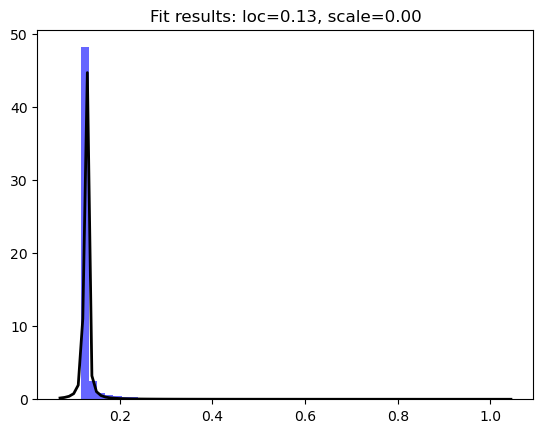

In [19]:
# Plot histogram of data
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')

# Plot fitted Cauchy distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = cauchy.pdf(x, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Fit results: loc=%.2f, scale=%.2f' % (loc, scale))
plt.show()


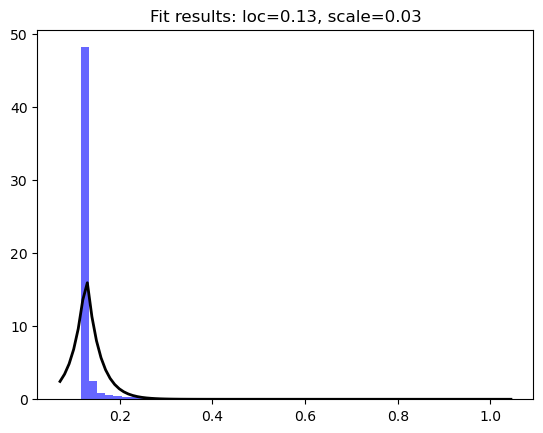

In [20]:
from scipy.stats import laplace

# Fit the Laplace distribution to the data
loc, scale = laplace.fit(data)

# Plot histogram of data
plt.hist(data, bins=50, density=True, alpha=0.6, color='b')

# Plot fitted Laplace distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = laplace.pdf(x, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Fit results: loc=%.2f, scale=%.2f' % (loc, scale))
plt.show()


In [22]:
kde

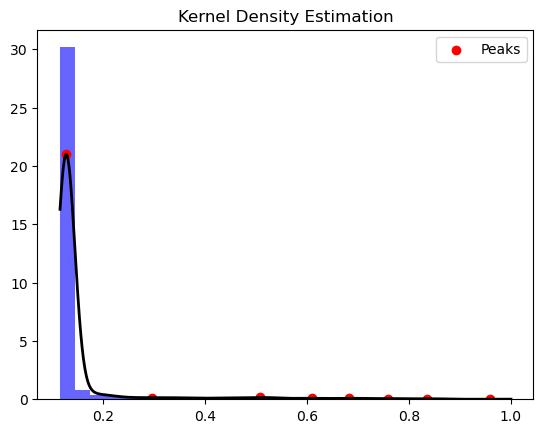

Peaks: [0.12756622 0.29585294 0.50753991 0.60939767 0.68202667 0.75908427
 0.83525616 0.95837118]
Percentiles: [0.1151661417338432, 0.12126173777622398, 0.12216987336590056, 0.12268741036718508, 0.12309855750025632, 0.1234313026819342, 0.12369312686269916, 0.12390512835242194, 0.12408028418051611, 0.12423969373751902, 0.1243762671913482, 0.12452230747589248, 0.12464466415993583, 0.12473363582737683, 0.12481933651392721, 0.1249015761341488, 0.12500820574732424, 0.12510853641468805, 0.12519645966301896, 0.12528365568975505, 0.1253611364801385, 0.12542623014587442, 0.1254986536394081, 0.12556877427265453, 0.1256433478874549, 0.1257141164729059, 0.12578897266586753, 0.12584691210981586, 0.12590948613994987, 0.12597950032375857, 0.126051677363897, 0.12610753280402048, 0.12616344375363878, 0.12622887217717038, 0.1262889754368095, 0.1263487022142829, 0.12641383853035032, 0.1264676905361566, 0.12652929740748584, 0.12658949663632918, 0.126652423168973, 0.12672156207028248, 0.12678640216091314, 

In [33]:
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema

# Estimate PDF using kernel density estimation (KDE)
kde = gaussian_kde(data)

# Evaluate PDF on a grid of points
x_grid = np.linspace(np.min(data), np.max(data), 1000)
pdf_values = kde(x_grid)

# Find peaks (local maxima)
peaks = x_grid[argrelextrema(pdf_values, np.greater)[0]]

# Estimate percentiles
percentiles = [np.percentile(data, p) for p in range(0, 101)]

# Plot histogram of data
plt.hist(data, bins=30, density=True, alpha=0.6, color='b')

# Plot KDE estimate
plt.plot(x_grid, pdf_values, 'k-', linewidth=2)

# Mark peaks
plt.scatter(peaks, kde(peaks), color='red', marker='o', label='Peaks')

plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

print("Peaks:", peaks)
print("Percentiles:", percentiles)


In [35]:
len(pdf_values)

1000

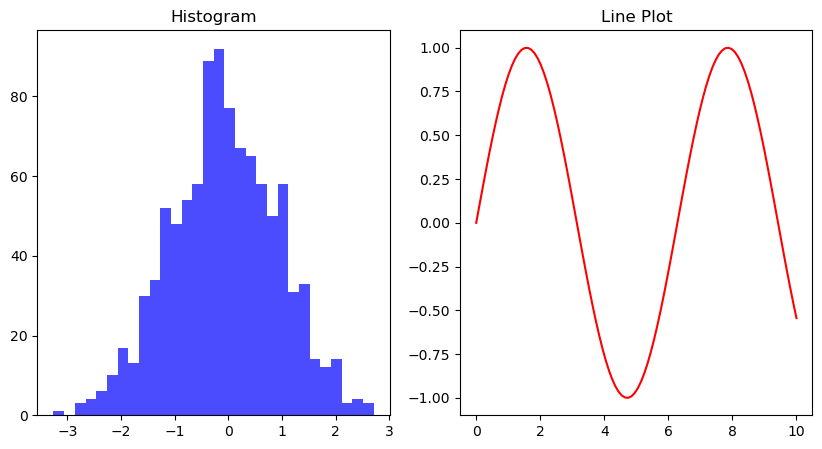

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the histogram and line plot
data_hist = np.random.randn(1000)
x_line = np.linspace(0, 10, 100)
y_line = np.sin(x_line)

# Create a figure object explicitly
fig = plt.figure(figsize=(10, 5))

# Add a subplot for the histogram
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
ax1.hist(data_hist, bins=30, alpha=0.7, color='blue')
ax1.set_title('Histogram')

# Add a subplot for the line plot
ax2 = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
ax2.plot(x_line, y_line, '-r')
ax2.set_title('Line Plot')

# Display the figure
plt.show()
